# 1. Exploratory data analysis

In [207]:
import pandas as pd
import numpy as np
import random

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score, GridSearchCV

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

The data should be downloaded from Kaggle: https://www.kaggle.com/c/titanic/data

Details (including stats) about Titanic disaster: https://www.wikiwand.com/en/RMS_Titanic

In [3]:
train_df = pd.read_csv('/Users/anton/temp_data/titanic/train.csv')
test_df = pd.read_csv('/Users/anton/temp_data/titanic/test.csv')

## 1.1. Overview of the data

In [4]:
train_df.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

In [5]:
test_df.columns.values

array(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

In [6]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We need to predict `Survived`.
* `Pclass` - class of travel
* `SibSp` - number of sibling/spouse aboard
* `Parch` - number of parent/child aboard
* `Embarked` - port in which passenger has embarked (C - Chesbourg, S - Southampton, Q - Queenstown)

## 1.2. Quality of the data

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [8]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


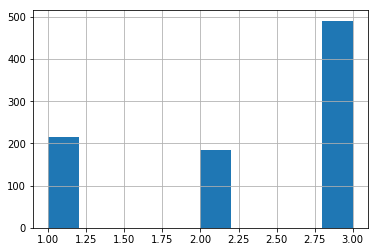

In [9]:
train_df.Pclass.hist();

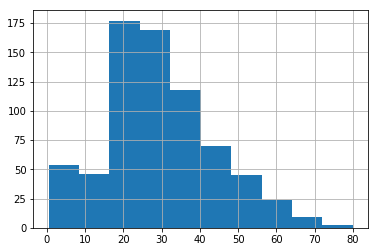

In [10]:
train_df.Age.hist();

In [11]:
train_df[train_df.SibSp > 0].shape[0] / train_df.shape[0]

0.3176206509539843

In [12]:
train_df[train_df.Parch > 0].shape[0] / train_df.shape[0]

0.23905723905723905

In [13]:
train_df[(train_df.SibSp == 0) & (train_df.Parch == 0)].shape[0] / train_df.shape[0]

0.6026936026936027

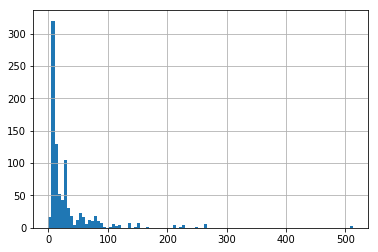

In [14]:
train_df.Fare.hist(bins = 100);

In [15]:
train_df[train_df.Fare > 0].Fare.min()

4.0125

In [16]:
train_df.describe(include=['O'])  # describe categorical

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Robins, Mrs. Alexander A (Grace Charity Laury)",male,CA. 2343,B96 B98,S
freq,1,577,7,4,644


Observations:
* `Name` may contain errors, titles, alternative names (for example, see `Futrelle, Mrs. Jacques Heath (Lily May Peel)`). All names are unique.
* `Cabin`, `Age`, `Embarked` contain missing values.
* There were 65% male passengers.
* There are 24% of duplicate tickets.
* Since there are duplicate cabins, several passengers shared a cabin.
* Most passengers (72%) embarked at Southampton.
* Actual number of passengers on Titanic was 2224 (see Wikipedia), train set contains 891 samples (40%).
* Survival rate on Titanic was 32% (see Wikipedia), for train set the rate is 38%.
* Most passengers had 3rd class tickets.
* Average age is roughly 30 years (max is 80).
* Most passengers (60%) travelled without siblings/spouses or children/parents. 32% had siblings/spouses aboard, 24% had children aboard.
* Fare varied significantly (min non-zero is 4, max is 512).

## 1.3. Feature correlation

### 1.3.1. Pclass vs Survived

Upper class passengers were more likely to survive.

In [17]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean() \
    .sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


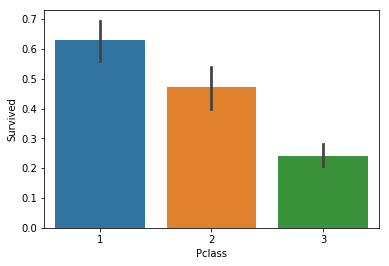

In [18]:
sns.barplot(x='Pclass', y='Survived', data=train_df);

### 1.3.2. Sex vs Survived

Women were more likely to survive.

In [19]:
train_df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


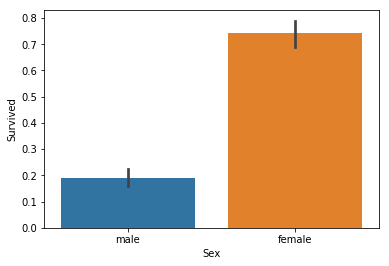

In [20]:
sns.barplot(x='Sex', y='Survived', data=train_df);

### 1.3.3. Age vs Survived

* Infants had higher survival rate.
* Oldest passenger survived.
* Passengers aged roughly 10-45 had lower survival rate.

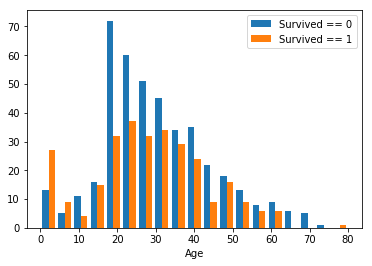

In [21]:
ages_of_survived = train_df[train_df.Survived == 0].Age.values
ages_of_not_survived = train_df[train_df.Survived == 1].Age.values
plt.hist([ages_of_survived , ages_of_not_survived], bins=np.linspace(0, 80, 20))
plt.xlabel('Age')
plt.legend(['Survived == 0', 'Survived == 1'])
plt.show();

By sex:

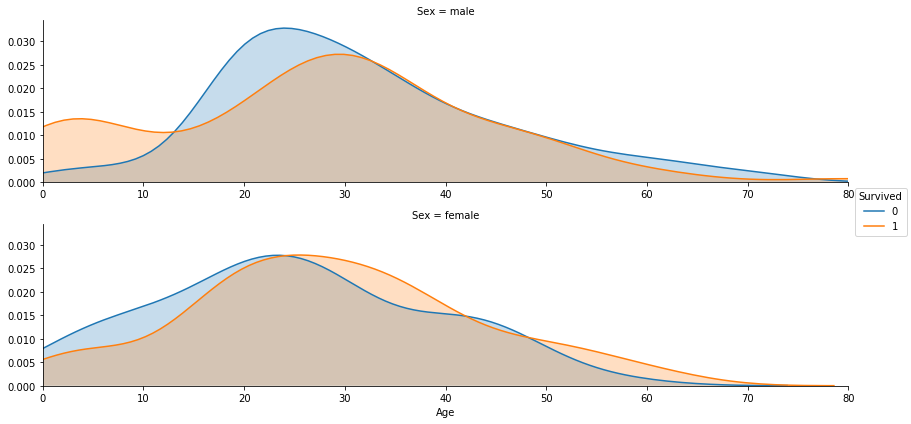

In [22]:
facet = sns.FacetGrid(train_df, hue='Survived', aspect=4, row='Sex')
facet.map(sns.kdeplot, 'Age', shade=True)
facet.set(xlim=(0, 80))
facet.add_legend();

### 1.3.4. Age vs Survived+Pclass

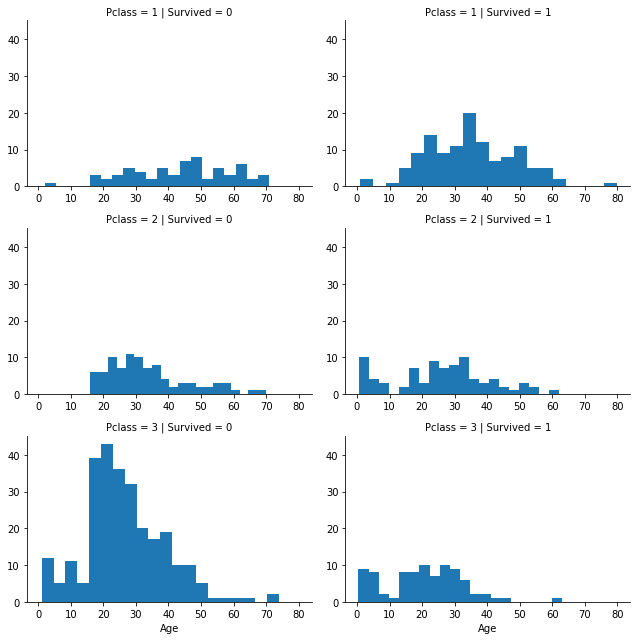

In [23]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', aspect=1.5)
grid.map(plt.hist, 'Age', bins=20);

### 1.3.5. Embarked+Pclass+Sex vs Survived

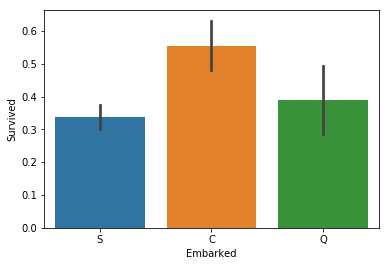

In [24]:
sns.barplot(x='Embarked', y='Survived', data=train_df);

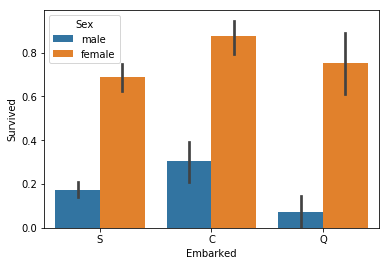

In [25]:
sns.barplot(x='Embarked', y='Survived', hue='Sex', data=train_df);

In [26]:
pd.pivot_table(train_df, index='Embarked', columns=['Pclass', 'Sex'], values='Survived')

Pclass           1                   2                   3          
Sex         female      male    female      male    female      male
Embarked                                                            
C         0.976744  0.404762  1.000000  0.200000  0.652174  0.232558
Q         1.000000  0.000000  1.000000  0.000000  0.727273  0.076923
S         0.958333  0.354430  0.910448  0.154639  0.375000  0.128302

### 1.3.6. Embarked vs Pclass

There was a smaller fraction of passenders holding 3rd class tickets in Chesbourg.

In [27]:
pd.pivot_table(train_df[['Embarked', 'Pclass']], index='Embarked', columns='Pclass', aggfunc=len, fill_value=0)

Pclass,1,2,3
Embarked,,,
C,85,17,66
Q,2,3,72
S,127,164,353


### 1.3.7. Pclass+Sex vs Survivied

In [28]:
pd.pivot_table(train_df, index='Pclass', columns='Sex', values='Survived')

Sex,female,male
Pclass,,
1,0.968085,0.368852
2,0.921053,0.157407
3,0.500000,0.135447


### 1.3.8. Pclass vs Sex

There are more men then women in Pclass=3.

In [29]:
pd.pivot_table(train_df[['Pclass', 'Sex']], index='Pclass', columns='Sex', aggfunc=len, fill_value=0)

Sex,female,male
Pclass,,
1,94,122
2,76,108
3,144,347


### 1.3.9. Fare vs Survived

Higher paying passengers had better survival rate.

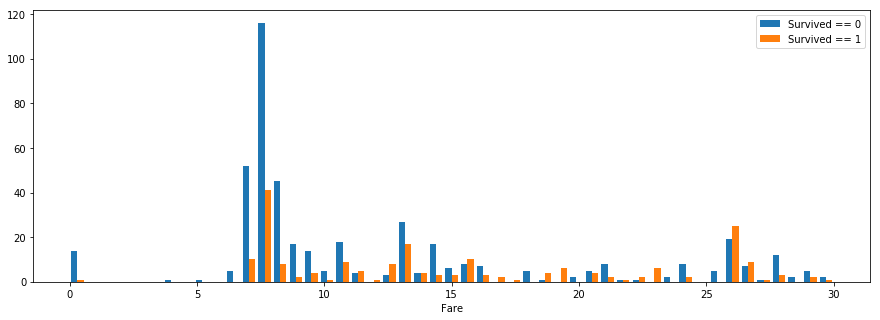

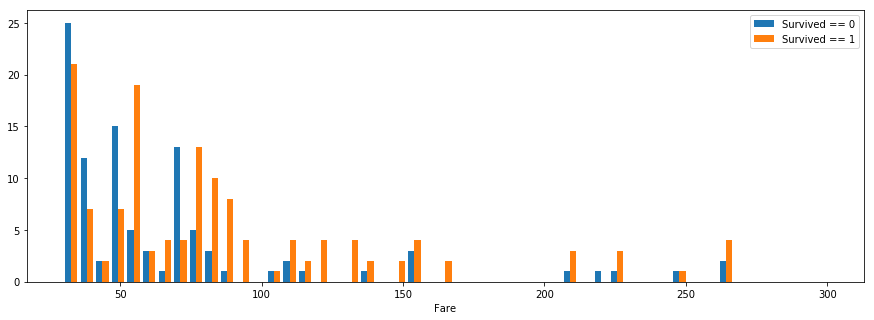

In [30]:
for low, high in [(0, 30), (30, 300)]:
    subset = train_df[(train_df.Fare >= low) & (train_df.Fare < high)]
    fare_of_survived = subset[subset.Survived == 0].Fare.values
    fare_of_not_survived = subset[subset.Survived == 1].Fare.values
    plt.figure(figsize=(15,5))
    plt.hist([fare_of_survived , fare_of_not_survived], bins=np.linspace(low, high, 50))
    plt.xlabel('Fare')
    plt.legend(['Survived == 0', 'Survived == 1'])
    plt.show();

Using Seaborn:

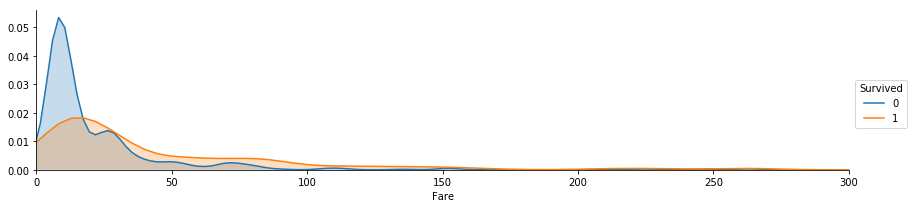

In [31]:
facet = sns.FacetGrid(train_df, hue='Survived', aspect=4)
facet.map(sns.kdeplot, 'Fare', shade=True)
facet.set(xlim=(0, 300))
facet.add_legend();

## 1.3.10. SibSb, Parch vs Survived

* SibSp - number of sibling/spouse aboard
* Parch - number of parent/child aboard

In [32]:
train_df[['SibSp', 'Survived']].groupby(['SibSp']).agg(['mean', 'count'])

Survived      
           mean count
SibSp                
0      0.345395   608
1      0.535885   209
2      0.464286    28
3      0.250000    16
4      0.166667    18
5      0.000000     5
8      0.000000     7

In [33]:
train_df[['Parch', 'Survived']].groupby(['Parch']).agg(['mean', 'count'])

Survived      
           mean count
Parch                
0      0.343658   678
1      0.550847   118
2      0.500000    80
3      0.600000     5
4      0.000000     4
5      0.200000     5
6      0.000000     1

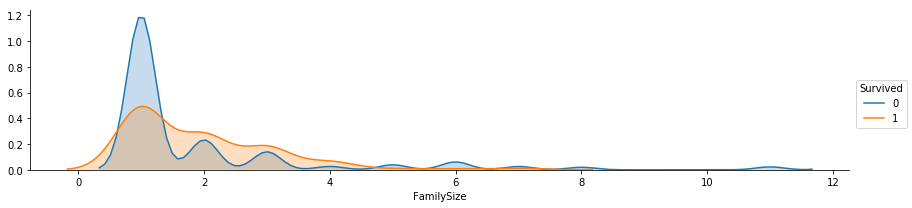

In [34]:
df_with_family_size = train_df.copy();
df_with_family_size['FamilySize'] = df_with_family_size.SibSp + df_with_family_size.Parch + 1

facet = sns.FacetGrid(df_with_family_size, hue='Survived', aspect=4)
facet.map(sns.kdeplot, 'FamilySize', shade=True)
facet.add_legend();

# 2. Data wrangling

## 2.1. Drop unused

In [35]:
train_df.drop(['PassengerId'], axis=1, inplace=True)

## 2.2. Create `Title` feature

In [36]:
# if expand=True, then it returns a column per capture group
train_df['Title'] = train_df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

In [37]:
pd.crosstab(train_df.Title, train_df.Sex)

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [38]:
train_df.Title.replace('Mlle', 'Miss', inplace=True)
train_df.Title.replace('Ms', 'Miss', inplace=True)
train_df.Title.replace('Mme', 'Mrs', inplace=True)

train_df.loc[~train_df['Title'].isin(['Master', 'Miss', 'Mr', 'Mrs']), 'Title'] = 'Rare'

In [39]:
train_df[['Title', 'Survived']].groupby(['Title']).mean()

,Survived
Title,
Master,0.575000
Miss,0.702703
Mr,0.156673
Mrs,0.793651
Rare,0.347826


In [40]:
pd.get_dummies(train_df.Title, prefix='Title').head()

,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,0,0,1,0,0
1,0,0,0,1,0
2,0,1,0,0,0
3,0,0,0,1,0
4,0,0,1,0,0


In [41]:
train_df = pd.concat([train_df, pd.get_dummies(train_df.Title, prefix='Title')], axis=1)
train_df.drop(['Title', 'Name'], axis=1, inplace=True)

In [42]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1,0,0
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,0,0,0,1,0
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,0,0,0
3,1,1,female,35.0,1,0,113803,53.1000,C123,S,0,0,0,1,0
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S,0,0,1,0,0


## 2.3. Convert `Sex` to number

In [43]:
train_df.replace({'Sex': {'female': 1, 'male': 0}}, inplace=True)
# Or: train_df['Sex'] = train_df.Sex.astype('category').cat.rename_categories([0, 1])
# Or: pd.get_dummies(train_df.Sex, drop_first=True)]

In [44]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,0,3,0,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1,0,0
1,1,1,1,38.0,1,0,PC 17599,71.2833,C85,C,0,0,0,1,0
2,1,3,1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,0,0,0
3,1,1,1,35.0,1,0,113803,53.1000,C123,S,0,0,0,1,0
4,0,3,0,35.0,0,0,373450,8.0500,NaN,S,0,0,1,0,0


## 2.4. Fill in missing values for `Age`

In [45]:
train_df_copy = train_df.copy()

In [46]:
train_df.Age.isnull().sum()

177

There are different ways to fill in missing value for `Age`:
* Simple way: fill in average value, or most frequent value.
* Noisy way: generate random number using mean and standard deviation.
* Drop rows containing null values.
* *Guess a correct age using other correlated features (`Gender` and `Pclass` look naturally correlated).* We use this approach.
* Use distinct constant, such as 0, or even create a separate column indicating where `Age` is absent.

In [47]:
train_df.corr().Age.drop(['Survived', 'Age']).abs().sort_values(ascending = False)

Title_Master    0.398827
Pclass          0.369226
SibSp           0.308247
Title_Miss      0.277827
Title_Mr        0.206341
Title_Rare      0.194639
Parch           0.189119
Title_Mrs       0.178069
Fare            0.096067
Sex             0.093254
Name: Age, dtype: float64

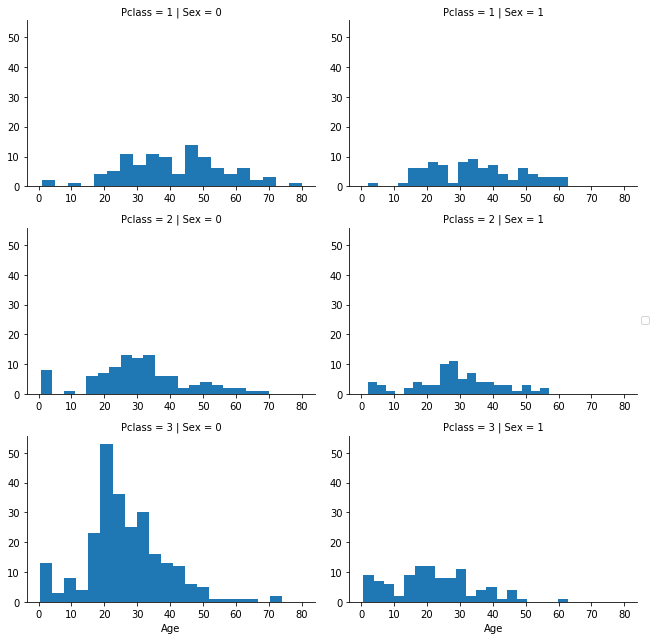

In [48]:
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', aspect=1.5)
grid.map(plt.hist, 'Age', bins=20)
grid.add_legend();

In [49]:
train_df[['Sex', 'Pclass', 'Age']].dropna().groupby(['Sex', 'Pclass']).mean()

Age
Sex Pclass           
0   1       41.281386
    2       30.740707
    3       26.507589
1   1       34.611765
    2       28.722973
    3       21.750000

In [50]:
for sex in range(0, 2):
    for pclass in range(1, 4):
        avg_age = round(train_df[(train_df.Sex == sex) & (train_df.Pclass == pclass)].Age.dropna().mean())
        train_df.loc[train_df.Age.isnull() & (train_df.Sex == sex) & (train_df.Pclass == pclass), 'Age'] = avg_age

In [51]:
train_df.Age.isnull().sum()

0

A better way is to use sklearn imputers: https://scikit-learn.org/stable/modules/impute.html

## 2.5. Create `AgeBand`

In [52]:
pd.cut(train_df['Age'], bins=5).head()

0    (16.336, 32.252]
1    (32.252, 48.168]
2    (16.336, 32.252]
3    (32.252, 48.168]
4    (32.252, 48.168]
Name: Age, dtype: category
Categories (5, interval[float64]): [(0.34, 16.336] < (16.336, 32.252] < (32.252, 48.168] < (48.168, 64.084] < (64.084, 80.0]]

In [53]:
train_df['AgeBand'] = pd.cut(train_df.Age, bins=5, labels=False)
train_df.drop(['Age'], axis=1, inplace=True)

In [54]:
train_df.head()

,Survived,Pclass,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,AgeBand
0,0,3,0,1,0,A/5 21171,7.2500,NaN,S,0,0,1,0,0,1
1,1,1,1,1,0,PC 17599,71.2833,C85,C,0,0,0,1,0,2
2,1,3,1,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,0,0,0,1
3,1,1,1,1,0,113803,53.1000,C123,S,0,0,0,1,0,2
4,0,3,0,0,0,373450,8.0500,NaN,S,0,0,1,0,0,2


In [55]:
train_df[['AgeBand', 'Survived']].groupby(['AgeBand']).mean()

,Survived
AgeBand,
0,0.550000
1,0.336714
2,0.412844
3,0.434783
4,0.090909


## 2.6 Create `Age*Class`

In [56]:
train_df['Age*Class'] = train_df.AgeBand * train_df.Pclass

In [57]:
train_df[['Age*Class', 'AgeBand', 'Pclass']].head()

,Age*Class,AgeBand,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3


## 2.7. Create `FamilySize` and `IsAlone`

In [58]:
train_df['FamilySize'] = train_df.SibSp + train_df.Parch + 1
train_df.drop(['SibSp', 'Parch'], axis=1, inplace=True)

In [59]:
train_df[['FamilySize', 'Survived']].groupby(['FamilySize']).agg(['mean', 'count'])

Survived      
                mean count
FamilySize                
1           0.303538   537
2           0.552795   161
3           0.578431   102
4           0.724138    29
5           0.200000    15
6           0.136364    22
7           0.333333    12
8           0.000000     6
11          0.000000     7

In [60]:
train_df['IsAlone'] = 0
train_df.loc[train_df.FamilySize == 1, 'IsAlone'] = 1
train_df.drop(['FamilySize'], axis=1, inplace=True)

In [61]:
train_df[['IsAlone', 'Survived']].groupby(['IsAlone']).mean()

,Survived
IsAlone,
0,0.505650
1,0.303538


In [62]:
train_df.head()

,Survived,Pclass,Sex,Ticket,Fare,Cabin,Embarked,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,AgeBand,Age*Class,IsAlone
0,0,3,0,A/5 21171,7.2500,NaN,S,0,0,1,0,0,1,3,0
1,1,1,1,PC 17599,71.2833,C85,C,0,0,0,1,0,2,2,0
2,1,3,1,STON/O2. 3101282,7.9250,NaN,S,0,1,0,0,0,1,3,1
3,1,1,1,113803,53.1000,C123,S,0,0,0,1,0,2,2,0
4,0,3,0,373450,8.0500,NaN,S,0,0,1,0,0,2,6,1


## 2.8. Convert `Embarked` to number

In [63]:
freq_port = train_df.Embarked.mode()[0]
freq_port

'S'

In [64]:
train_df.Embarked.fillna(freq_port, inplace=True)

In [65]:
train_df[['Embarked', 'Survived']].groupby(['Embarked']).mean()

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.339009


In [66]:
train_df = pd.concat([train_df, pd.get_dummies(train_df.Embarked, prefix='Embarked')], axis=1)
train_df.drop(['Embarked'], axis=1, inplace=True)

In [67]:
train_df.head()

,Survived,Pclass,Sex,Ticket,Fare,Cabin,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,AgeBand,Age*Class,IsAlone,Embarked_C,Embarked_Q,Embarked_S
0,0,3,0,A/5 21171,7.2500,NaN,0,0,1,0,0,1,3,0,0,0,1
1,1,1,1,PC 17599,71.2833,C85,0,0,0,1,0,2,2,0,1,0,0
2,1,3,1,STON/O2. 3101282,7.9250,NaN,0,1,0,0,0,1,3,1,0,0,1
3,1,1,1,113803,53.1000,C123,0,0,0,1,0,2,2,0,0,0,1
4,0,3,0,373450,8.0500,NaN,0,0,1,0,0,2,6,1,0,0,1


## 2.9. Create `FareBand`

For test set we also need to fill the missing value for `Fare`.

In [68]:
train_df['FareBand'] = pd.qcut(train_df.Fare, 4, labels=False)  # put into equal-sized buckets
train_df.drop(['Fare'], axis=1, inplace=True)

In [69]:
train_df.head()

,Survived,Pclass,Sex,Ticket,Cabin,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,AgeBand,Age*Class,IsAlone,Embarked_C,Embarked_Q,Embarked_S,FareBand
0,0,3,0,A/5 21171,NaN,0,0,1,0,0,1,3,0,0,0,1,0
1,1,1,1,PC 17599,C85,0,0,0,1,0,2,2,0,1,0,0,3
2,1,3,1,STON/O2. 3101282,NaN,0,1,0,0,0,1,3,1,0,0,1,1
3,1,1,1,113803,C123,0,0,0,1,0,2,2,0,0,0,1,3
4,0,3,0,373450,NaN,0,0,1,0,0,2,6,1,0,0,1,1


In [70]:
train_df[['FareBand', 'Survived']].groupby(['FareBand']).agg(['mean', 'count'])

Survived      
              mean count
FareBand                
0         0.197309   223
1         0.303571   224
2         0.454955   222
3         0.581081   222

## 2.10. Create cabin category features

In [71]:
train_df.Cabin.dropna().head(n=10)

1             C85
3            C123
6             E46
10             G6
11           C103
21            D56
23             A6
27    C23 C25 C27
31            B78
52            D33
Name: Cabin, dtype: object

In [72]:
train_df['CabinCategory'] = train_df.Cabin.fillna('U').map(lambda c: c[0])

In [73]:
train_df[['CabinCategory', 'Survived']].groupby(['CabinCategory']).agg(['mean', 'count'])

Survived      
                   mean count
CabinCategory                
A              0.466667    15
B              0.744681    47
C              0.593220    59
D              0.757576    33
E              0.750000    32
F              0.615385    13
G              0.500000     4
T              0.000000     1
U              0.299854   687

In [74]:
cabin_dummies = pd.get_dummies(train_df.CabinCategory, prefix='Cabin')
cabin_dummies.head()

,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1


In [75]:
train_df = pd.concat([train_df.drop(['Cabin', 'CabinCategory'], axis=1), cabin_dummies], axis=1)

In [76]:
train_df.head()

,Survived,Pclass,Sex,Ticket,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,AgeBand,...,FareBand,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,0,3,0,A/5 21171,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,1,1,1,PC 17599,0,0,0,1,0,2,...,3,0,0,1,0,0,0,0,0,0
2,1,3,1,STON/O2. 3101282,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
3,1,1,1,113803,0,0,0,1,0,2,...,3,0,0,1,0,0,0,0,0,0
4,0,3,0,373450,0,0,1,0,0,2,...,1,0,0,0,0,0,0,0,0,1


## 2.11. Create ticket class features

In [77]:
train_df.Ticket.dropna().head(n=10)

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
5              330877
6               17463
7              349909
8              347742
9              237736
Name: Ticket, dtype: object

In [78]:
def get_ticket_class(ticket):
    parts = map(lambda p: p.strip(), ticket.replace('/', '').replace('.', '').split())
    parts = [part for part in parts if not part.isdigit()]
    return parts[0] if len(parts) > 0 else 'U'

get_ticket_class('STON/O2. 3101282')

'STONO2'

In [79]:
train_df['TicketClass'] = train_df.Ticket.map(get_ticket_class)

In [80]:
train_df[['TicketClass', 'Survived']].groupby(['TicketClass']).agg(['mean', 'count'])

Survived      
                 mean count
TicketClass                
A4           0.000000     7
A5           0.095238    21
AS           0.000000     1
C            0.400000     5
CA           0.341463    41
CASOTON      0.000000     1
FC           0.000000     1
FCC          0.800000     5
Fa           0.000000     1
LINE         0.250000     4
PC           0.650000    60
PP           0.666667     3
PPP          0.500000     2
SC           1.000000     1
SCA4         0.000000     1
SCAH         0.666667     3
SCOW         0.000000     1
SCPARIS      0.428571     7
SCParis      0.500000     4
SOC          0.166667     6
SOP          0.000000     1
SOPP         0.000000     3
SOTONO2      0.000000     2
SOTONOQ      0.133333    15
SP           0.000000     1
STONO        0.416667    12
STONO2       0.500000     6
SWPP         1.000000     2
U            0.384266   661
WC           0.100000    10
WEP          0.333333     3

In [82]:
train_df.drop(['Ticket', 'TicketClass'], axis=1, inplace=True)

# 3. Create model

In [83]:
x_train = train_df.drop('Survived', axis=1)
features = x_train.columns
y_train = train_df.Survived

## 3.1. Logistic Regression

In [159]:
logreg = LogisticRegression(random_state=42)
logreg

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [166]:
logreg_accuracy = cross_val_score(logreg, x_train, y_train, cv=2, scoring='accuracy').mean()
print('{0:.2%}'.format(logreg_accuracy))

78.56%


In [165]:
pd.DataFrame(logreg.fit(x_train, y_train).coef_[0], index=features, columns=['Coefficient']) \
    .sort_values(by='Coefficient')

,Coefficient
Pclass,-0.892111
Title_Mr,-0.838740
Title_Rare,-0.513277
Cabin_U,-0.375978
Cabin_G,-0.344977
AgeBand,-0.311428
Cabin_T,-0.293001
Cabin_C,-0.130397
Age*Class,-0.062601
FareBand,-0.026856


## 3.2. Support Vector Machine

In [168]:
svc = SVC(random_state=42)
svc

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=42,
    shrinking=True, tol=0.001, verbose=False)

In [169]:
svm_accuracy = cross_val_score(svc, x_train, y_train, cv=2, scoring='accuracy').mean()
print('{0:.2%}'.format(svm_accuracy))

78.90%


## 3.3. Decision Tree

In [170]:
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [171]:
decision_tree_accuracy = cross_val_score(decision_tree, x_train, y_train, cv=2, scoring='accuracy').mean()
print('{0:.2%}'.format(decision_tree_accuracy))

76.10%


In [172]:
pd.DataFrame(decision_tree.fit(x_train, y_train).feature_importances_, index=features, columns=['Importance']) \
    .sort_values(by='Importance', ascending=False)

,Importance
Title_Mr,0.447383
Pclass,0.119137
FareBand,0.094300
Title_Rare,0.051972
Cabin_U,0.050700
IsAlone,0.040794
Age*Class,0.040617
AgeBand,0.038972
Embarked_S,0.024333
Embarked_C,0.019685


In [173]:
decision_tree.get_n_leaves(), decision_tree.get_depth()

(157, 14)

## 3.4. Random Forest

`RandomForestClassifier` provides `oob_score`, but unfortunately there is not enough data to compute it reliably.

In [180]:
random_forest = RandomForestClassifier(random_state=42, n_estimators=100)
random_forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [181]:
random_forest_accuracy = cross_val_score(random_forest, x_train, y_train, cv=2, scoring='accuracy').mean()
print('{0:.2%}'.format(random_forest_accuracy))

79.24%


In [182]:
pd.DataFrame(random_forest.fit(x_train, y_train).feature_importances_, index=features, columns=['Importance']) \
    .sort_values(by='Importance', ascending=False)

,Importance
Title_Mr,0.163020
Sex,0.157071
FareBand,0.114149
Pclass,0.098819
Age*Class,0.079618
AgeBand,0.052783
Title_Miss,0.049782
Cabin_U,0.049730
Title_Mrs,0.047343
IsAlone,0.039862


## 3.5. Gradient Boosting: sklearn

In [204]:
gradient_boosting = GradientBoostingClassifier(random_state=42, max_depth=10)
gradient_boosting

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=10,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [205]:
gradient_boosting_accuracy = cross_val_score(gradient_boosting, x_train, y_train, cv=2, scoring='accuracy').mean()
print('{0:.2%}'.format(gradient_boosting_accuracy))

75.54%


In [185]:
gradient_boosting.fit(x_train, y_train)

pd.DataFrame(gradient_boosting.feature_importances_, index=features, columns=['Importance']) \
    .sort_values(by='Importance', ascending=False)

,Importance
Title_Mr,0.446719
Pclass,0.114123
FareBand,0.076413
Cabin_U,0.057028
Title_Rare,0.052106
AgeBand,0.047568
Age*Class,0.041311
IsAlone,0.036870
Embarked_S,0.028634
Embarked_C,0.019273


## 3.6. Models comparison

In [201]:
comparison = {
    'Logistic Regression': logreg_accuracy,
    'SVM': svm_accuracy,
    'Decision Tree': decision_tree_accuracy,
    'Random Forest': random_forest_accuracy,
    'Gradient Boosting': gradient_boosting_accuracy
}

pd.DataFrame(list(comparison.items()), columns=['Model', 'Accuracy']) \
    .sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
3,Random Forest,0.792382
1,SVM,0.788983
0,Logistic Regression,0.785638
2,Decision Tree,0.760964
4,Gradient Boosting,0.755353


## 3.7. Recursive feature elimination

Features are ranked using model's `coef_` or `feature_importances_` attribute. On each step we eliminate a feature with a lowest rank.

In [113]:
random_forest = RandomForestClassifier(random_state=42, n_estimators=100)
rfecv = RFECV(estimator=random_forest, step=1, cv=StratifiedKFold(2), scoring='accuracy')
rfecv.fit(x_train, y_train)

RFECV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                       criterion='gini', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

In [229]:
print("Optimal number of features : {}".format(rfecv.n_features_))

Optimal number of features : 6


In [231]:
print("Optimal accuracy : {0:.2%}".format(rfecv.grid_scores_[rfecv.n_features_ - 1]))

Optimal accuracy : 82.04%


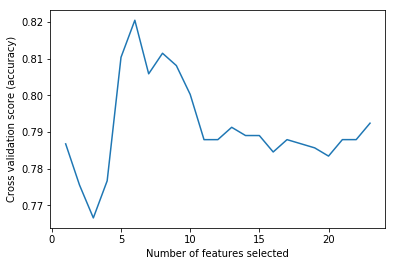

In [118]:
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_);

Rankings of features (selected features have rank 1):

In [133]:
pd.DataFrame(rfecv.ranking_, columns=['Rank'], index=features).sort_values(by='Rank')

,Rank
Pclass,1
FareBand,1
Age*Class,1
Title_Mr,1
Cabin_U,1
Sex,1
AgeBand,2
Embarked_S,3
Title_Miss,4
Title_Mrs,5


Which features were selected?

In [127]:
features[rfecv.support_]

Index(['Pclass', 'Sex', 'Title_Mr', 'Age*Class', 'FareBand', 'Cabin_U'], dtype='object')

In [215]:
x_train_selected = x_train[features[rfecv.support_]]

## 3.8. Find optimal hyperparameters for Random Forest

* `n_estimators` - number of trees in the forest
* `criterion` - criterion to split (`gini` for Gini impurity or `entropy` for information gain)
* `max_depth` - max depth of the tree (if None, then nodes are expanded until pure or node contain `min_samples_split`)
* `min_samples_split` - min number of samples required to split a node
* `min_samples_leaf` - min number of samples to be a leaf node
* `max_features` - number of features to consider when choosing best split
* `boostrap` - use random subset of samples at each split

In [238]:
%%time

params = {
    'n_estimators': [10, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3],
    'max_features': [2, 3, 6],
    'bootstrap': [True, False]}

random_forest = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(random_forest, param_grid=params, cv=2, iid=False)

grid_search.fit(x_train_selected, y_train)

CPU times: user 52.8 s, sys: 176 ms, total: 53 s
Wall time: 53 s


In [239]:
print("Optimal accuracy : {0:.2%}".format(grid_search.best_score_))

Optimal accuracy : 82.04%


In [240]:
grid_search.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 10}

In [241]:
pd.set_option('display.max_colwidth', 200)
pd.DataFrame(grid_search.cv_results_).sort_values(by='rank_test_score')[['mean_test_score', 'params']].head()

,mean_test_score,params
304,0.820431,"{'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 10}"
377,0.819310,"{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}"
412,0.819310,"{'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 10}"
41,0.818189,"{'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}"
77,0.818189,"{'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}"


Interesting solutions:

* https://www.kaggle.com/startupsci/titanic-data-science-solutions
* https://www.kaggle.com/helgejo/an-interactive-data-science-tutorial
* https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy
* https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8
* https://blog.socialcops.com/technology/data-science/machine-learning-python/
* https://datascienceplus.com/would-you-survive-the-titanic-getting-started-in-python/
* https://www.kaggle.com/garethjns/titanicsexism-fairness-in-ml

Documentation:

* http://queirozf.com/entries/one-hot-encoding-a-feature-on-a-pandas-dataframe-an-example
* http://martinhjelm.github.io/2017/11/12/Pandas-Replacing-Strings-In-A-Column/
* https://stackoverflow.com/questions/17114904/python-pandas-replacing-strings-in-dataframe-with-numbers
* https://machinelearningmastery.com/handle-missing-data-python/
* https://scikit-learn.org/stable/modules/impute.html
* https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html
* https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html
